In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
cd /content/gdrive/MyDrive/SensoVision/

/content/gdrive/MyDrive/SensoVision


In [ ]:
!ls

class_names.csv        SenoVision-ResNet34.ipynb  test	    train
sample_submission.csv  task1.tar		  test.csv  train.csv


In [ ]:
#!tar -xvf task1.tar

In [ ]:
import pandas as pd
import os
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
def arrange_data(path, df):
    for _, i in df.iterrows():
        if not os.path.exists(path+str(i[1])):
            os.makedirs(path+str(i[1]))
        try:
            os.rename(path+str(i[0]), path+str(i[1])+'/'+str(i[0]))
        except Exception as e:
            print(e)
#arrange_data('train/', train_df)
#arrange_data('test/', test_df)

In [ ]:
from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode

In [ ]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(30),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])
    ]),
}
data_dir = '/content/gdrive/MyDrive/SensoVision/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), 
                                          transform=data_transforms[x]) 
                                          for x in ['train', 'test']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64, 
                                              shuffle=True, num_workers=4)
                                              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes                                            
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [ ]:
print(dataset_sizes)
print(len(image_datasets['train'].classes), ' ', len(image_datasets['test'].classes))

{'train': 8144, 'test': 403}
196   196


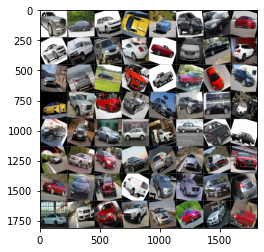

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated

# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=None)

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=30):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0
    train_loss = []
    train_acc = []
    test_loss = []
    test_acc = []
    step = 0
    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'test']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                step += 1

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)
                    #if step % 50 == 0 and phase == 'train':
                    #    print('Step No {:.4f} Training Loss {:.4f}'.format(step, loss.item()))
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train' and scheduler is not None:
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]
            if phase == 'train':
                train_loss.append(epoch_loss)
                train_acc.append(epoch_acc)
            elif phase == 'test':
                test_loss.append(epoch_loss)
                test_acc.append(epoch_acc)
            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'test' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_loss, train_acc, test_loss, test_acc

In [ ]:
model = models.resnet34(pretrained=True)
num_ftrs = model.fc.in_features
#num_ftrs = model.last_channel

model.fc = nn.Linear(num_ftrs, len(class_names))
#model.classifier[1] = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

criterion = nn.CrossEntropyLoss()

# All parameters are being optimized
optimizer = optim.Adam(model.parameters(), lr=0.001)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
model_ft, train_loss, train_acc, test_loss, test_acc = train_model(model, criterion, optimizer, scheduler=None, num_epochs=30)

Epoch 0/29
----------
train Loss: 5.3281 Acc: 0.0085
test Loss: 5.1858 Acc: 0.0099

Epoch 1/29
----------
train Loss: 5.1658 Acc: 0.0126
test Loss: 5.1171 Acc: 0.0074

Epoch 2/29
----------
train Loss: 4.9612 Acc: 0.0209
test Loss: 5.4819 Acc: 0.0298

Epoch 3/29
----------
train Loss: 4.6196 Acc: 0.0362
test Loss: 4.6632 Acc: 0.0347

Epoch 4/29
----------
train Loss: 4.2484 Acc: 0.0605
test Loss: 4.3125 Acc: 0.0546

Epoch 5/29
----------
train Loss: 3.8250 Acc: 0.0990
test Loss: 4.5695 Acc: 0.0571

Epoch 6/29
----------
train Loss: 3.4328 Acc: 0.1530
test Loss: 3.7597 Acc: 0.1290

Epoch 7/29
----------
train Loss: 3.0059 Acc: 0.2183
test Loss: 3.3481 Acc: 0.2084

Epoch 8/29
----------
train Loss: 2.5826 Acc: 0.3091
test Loss: 3.0338 Acc: 0.2258

Epoch 9/29
----------
train Loss: 2.2308 Acc: 0.3883
test Loss: 2.9657 Acc: 0.2630

Epoch 10/29
----------
train Loss: 1.8862 Acc: 0.4705
test Loss: 2.5452 Acc: 0.3524

Epoch 11/29
----------
train Loss: 1.6138 Acc: 0.5420
test Loss: 2.1040 Acc

In [ ]:
torch.save(model, data_dir + "resnet34.pt")

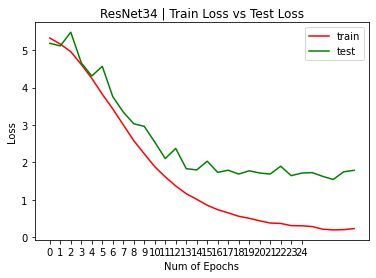

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(range(len(train_loss)), train_loss,'r')
plt.plot(range(len(test_loss)), test_loss,'g')
plt.xticks(np.arange(0, 25, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Loss")
plt.title("ResNet34 | Train Loss vs Test Loss")
plt.legend(['train','test'])

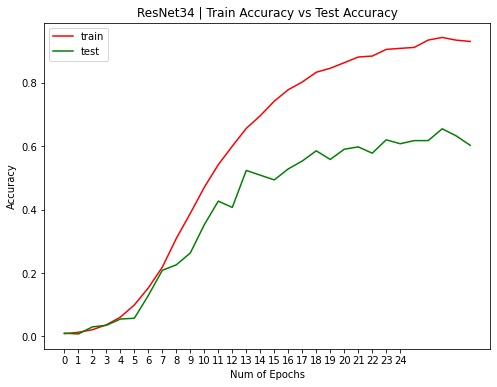

In [ ]:
plt.plot(range(len(train_acc)), train_acc,'r')
plt.plot(range(len(test_acc)), test_acc,'g')
plt.xticks(np.arange(0, 25, 1.0))
plt.rcParams['figure.figsize'] = (8, 6)
plt.xlabel("Num of Epochs")
plt.ylabel("Accuracy")
plt.title("ResNet34 | Train Accuracy vs Test Accuracy")
plt.legend(['train','test'])

In [ ]:
from PIL import Image
def process_image(image):
    
    # Process a PIL image for use in a PyTorch model

    # Converting image to PIL image using image file path
    pil_im = Image.open(f'{image}')

    # Building image transform
    transform = transforms.Compose([transforms.Resize((224,224)),
                                    transforms.CenterCrop(224),
                                    transforms.ToTensor(),
                                    transforms.Normalize([0.5, 0.5, 0.5], 
                                                         [0.5, 0.5, 0.5])]) 
    
    # Transforming image for use with network
    pil_tfd = transform(pil_im)
    
    # Converting to Numpy array 
    array_im_tfd = np.array(pil_tfd)
    
    return array_im_tfd

In [ ]:
def imshow(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

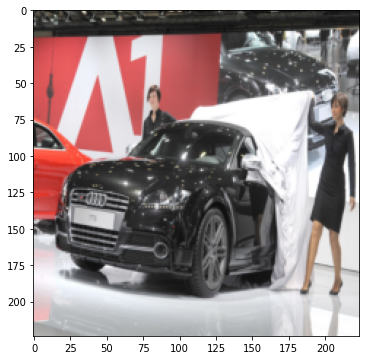

In [ ]:
imshow(process_image('test/14/01811.jpg'))

In [ ]:
def predict(image_path, model, topk=5):
    # Implement the code to predict the class from an image file   
    
    # Loading model - using .cpu() for working with CPUs
    loaded_model = model.cpu()
    # Pre-processing image
    img = process_image(image_path)
    # Converting to torch tensor from Numpy array
    img_tensor = torch.from_numpy(img).type(torch.FloatTensor)
    # Adding dimension to image to comply with (B x C x W x H) input of model
    img_add_dim = img_tensor.unsqueeze_(0)

    # Setting model to evaluation mode and turning off gradients
    loaded_model.eval()
    with torch.no_grad():
        # Running image through network
        output = loaded_model.forward(img_add_dim)
        
    #conf, predicted = torch.max(output.data, 1)   
    probs_top = output.topk(topk)[0]
    predicted_top = output.topk(topk)[1]
    
    # Converting probabilities and outputs to lists
    conf = np.array(probs_top)[0]
    predicted = np.array(predicted_top)[0]
        
    #return probs_top_list, index_top_list
    return conf, predicted

In [ ]:
df_class = pd.read_csv("class_names.csv", header=None)
classes_ = df_class[0].to_list()
classes_.sort()
c_to_idx = {classes_[i]: i for i in range(len(classes_))}
print(classes_, c_to_idx)

['AM General Hummer SUV 2000', 'Acura Integra Type R 2001', 'Acura RL Sedan 2012', 'Acura TL Sedan 2012', 'Acura TL Type-S 2008', 'Acura TSX Sedan 2012', 'Acura ZDX Hatchback 2012', 'Aston Martin V8 Vantage Convertible 2012', 'Aston Martin V8 Vantage Coupe 2012', 'Aston Martin Virage Convertible 2012', 'Aston Martin Virage Coupe 2012', 'Audi 100 Sedan 1994', 'Audi 100 Wagon 1994', 'Audi A5 Coupe 2012', 'Audi R8 Coupe 2012', 'Audi RS 4 Convertible 2008', 'Audi S4 Sedan 2007', 'Audi S4 Sedan 2012', 'Audi S5 Convertible 2012', 'Audi S5 Coupe 2012', 'Audi S6 Sedan 2011', 'Audi TT Hatchback 2011', 'Audi TT RS Coupe 2012', 'Audi TTS Coupe 2012', 'Audi V8 Sedan 1994', 'BMW 1 Series Convertible 2012', 'BMW 1 Series Coupe 2012', 'BMW 3 Series Sedan 2012', 'BMW 3 Series Wagon 2012', 'BMW 6 Series Convertible 2007', 'BMW ActiveHybrid 5 Sedan 2012', 'BMW M3 Coupe 2012', 'BMW M5 Sedan 2010', 'BMW M6 Convertible 2010', 'BMW X3 SUV 2012', 'BMW X5 SUV 2007', 'BMW X6 SUV 2012', 'BMW Z4 Convertible 2012

In [ ]:
image_path = 'test/14/06750.jpg'
conf1, predicted1 = predict(image_path, model, topk=5)
print(conf1)
print(classes_[int(class_names[predicted1[0]])])

[8.827504  8.584922  5.5692577 5.343001  4.4527574]
Audi S5 Coupe 2012


In [ ]:
def plot_solution(image_path, model=model, classes_=classes_):
    carname = classes_[int(image_path.split('/')[1])]
    conf2, predicted1 = predict(image_path, model, topk=5)
    # Converting classes to names
    names = []
    for i in range(5):

        names += [classes_[int(class_names[predicted1[i]])]]


    # Creating PIL image
    image = Image.open(image_path)

    # Plotting test image and predicted probabilites
    f, ax = plt.subplots(2,figsize = (6,10))

    ax[0].imshow(image)
    ax[0].set_title(carname)

    y_names = np.arange(len(names))
    ax[1].barh(y_names, conf2/conf2.sum(), color='darkblue')
    ax[1].set_yticks(y_names)
    ax[1].set_yticklabels(names)
    ax[1].invert_yaxis() 

    plt.show()

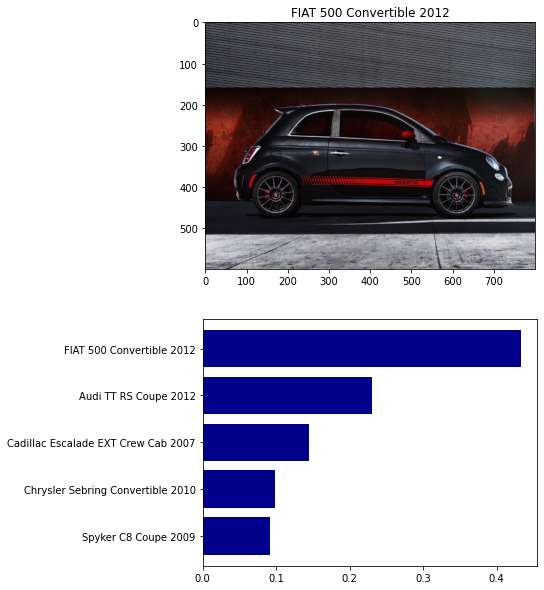

In [ ]:
cardir='test/99/03524.jpg'
plot_solution(cardir, model)

In [ ]:
test_dataloaders = torch.utils.data.DataLoader(image_datasets['test'], batch_size=image_datasets['test'].__len__(), 
                                              shuffle=True, num_workers=4)

In [ ]:
model.to(device)
model.eval()
for inputs, labels in test_dataloaders:
    inputs = inputs.to(device)
    labels = labels.to(device)
            
    with torch.no_grad():
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

In [ ]:
acc = accuracy_score(preds.cpu().numpy(), labels.cpu().numpy())
macro_f1_score = f1_score(preds.cpu().numpy(), labels.cpu().numpy(), average='macro')
print("Accuracy {:.04f} and Macro F1 Score {:.04f}".format(acc, macro_f1_score))

Accuracy 0.6551 and Macro F1 Score 0.6256


In [ ]:
df_test = pd.read_csv("test.csv")
y_pred = []
y_actual = []
for i, j in zip(df_test['image_name'], df_test['label']):
    try:
        conf1, predicted1 = predict('test/'+str(j)+'/'+str(i), model, topk=5)
        y_pred.append(int(class_names[predicted1[0]]))
        y_actual.append(j)
    except:
        y_pred.append(j)
        y_actual.append(j)
df_test['label'] = y_pred
df_test.to_csv("submission.csv", index=False)